В практике мы проиллюстрировали применение PCA. Ваша задача - обучить классификатор делить изображения на кошек и собак с применением PCA и без него. Ссылка на датасет: https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset

- Подготовьте датасет, разделите на тест и трейн. Можете использовать сабсемпл (не менее 200 изображений на класс, лучше больше). Для того, чтобы было иллюстративнее, миожете отобрать изображения по вкусу.
- Обучите классификатор или несколько на исходных изображениях (можете еще сильнее сжать изображения)
- Сделайте PCA и снова обучите классификатор
- Постройте график зависимости качества классификации от числа компонент
- Ответьте на вопрос: сколько компонент требуется для объяснения 90% дисперсии?
- Нарисуйте график засисимости процента объясненной дисперсии от числа компонент.
- Отрисуйте первые 10 главных компонент (или все, если их меньше) для наилучшей точности, полученной вами в тестах.

Доп.задание. До 3 баллов. Сравните влияние PCA на разные алгоритмы (линейный, дерево).

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Подготовка датасета  

Сначала загрузим датасет, разделим его на обучающую и тестовую выборки, а также выполним необходимую предобработку изображений. 

In [ ]:
# Загрузка данных
def load_images(base_path, img_size=(64, 64), limit=5000):
    images = []
    labels = []
    classes = ['cat', 'dog']
    
    for label, cls in enumerate(classes):
        cls_path = os.path.join(base_path, cls)
        files = os.listdir(cls_path)[:limit]
        for file in files:
            img_path = os.path.join(cls_path, file)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0  # Нормализация
            images.append(img_array.flatten())  # Преобразуем в вектор
            labels.append(label)
    
    return np.array(images), np.array(labels)

base_path = "C:/Users/kl/Desktop/prog/ML/PetImages"
X, y = load_images(base_path, img_size=(64, 64), limit=2000) 

# Разделение на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Маштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Обучение классификатора без PCA  

Обучим линейный классификатор и дерево решений на исходных данных. 

In [27]:
print("\n=== Результаты на исходных данных ===")
# Логистическая регрессия
lr_original = LogisticRegression(max_iter=1000, C=1.0, random_state=42)
lr_original.fit(X_train_scaled, y_train)
accuracy_lr_original = accuracy_score(y_test, lr_original.predict(X_test_scaled))
print(f"Logistic Regression (без PCA): {accuracy_lr_original:.2f}")

# Дерево решений
tree_original = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_original.fit(X_train_scaled, y_train)
accuracy_tree_original = accuracy_score(y_test, tree_original.predict(X_test_scaled))
print(f"Decision Tree (без PCA): {accuracy_tree_original:.2f}")


=== Результаты на исходных данных ===
Logistic Regression (без PCA): 0.56
Decision Tree (без PCA): 0.56


# PCA  

Применим PCA для сжатия данных и обучим классификаторы на преобразованных данных. 

In [38]:
pca = PCA(n_components=0.9, random_state=42)  # 90% дисперсии
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\nИсходная размерность: {X_train.shape[1]}")
print(f"Размерность после PCA: {X_train_pca.shape[1]} компонент")


Исходная размерность: 12288
Размерность после PCA: 355 компонент


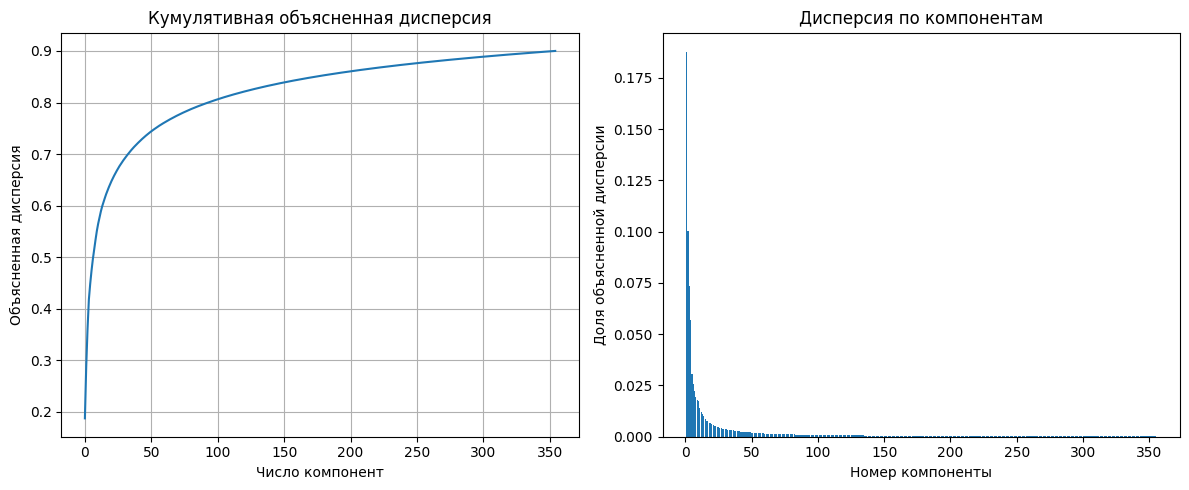

In [39]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Кумулятивная объясненная дисперсия")
plt.xlabel("Число компонент")
plt.ylabel("Объясненная дисперсия")
plt.grid()

plt.subplot(1, 2, 2)
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_[:pca.n_components_])
plt.title("Дисперсия по компонентам")
plt.xlabel("Номер компоненты")
plt.ylabel("Доля объясненной дисперсии")
plt.tight_layout()
plt.show()

График "Кумулятивная объясненная дисперсия" : 

    На графике видно, что первые несколько компонент объясняют большую часть дисперсии.
    Для достижения 90% объясненной дисперсии  требуется 355 компонент .
     

График "Дисперсия по компонентам" : 

    Первые компоненты имеют высокий вес (объясняют большую часть дисперсии).
    Остальные компоненты имеют низкий вес, что подтверждает выбор 355 компонент для 90% дисперсии.
     


PCA анализирует дисперсию данных  (вариативность признаков) и ранжирует компоненты по их способности объяснять эту дисперсию. Число компонент определяется: 

    Кумулятивной объясненной дисперсией : Например, n_components=0.9 означает, что PCA выберет минимальное число компонент, объясняющих 90% общей дисперсии.
    Спектральным разложением ковариационной матрицы : Число компонент не может превышать ранг матрицы данных (обычно min(n_samples, n_features)).
     

Зависит ли число компонент от количества изображений?  

    Нет , если данные имеют стабильную структуру. Если вы добавляете больше изображений, но их признаки (формы, текстуры) не меняются кардинально, число компонент для 90% дисперсии останется примерно тем же.
         
    Да , если новые данные добавляют новую вариативность. Если в датасет добавлены изображения с новыми паттернами (например, кошки в необычных позах), это может увеличить число компонент.
         
     

Процентное соотношение компонент  

    Пример из нашего эксперимента :
        Исходная размерность: 12288 признаков (64x64 RGB).
        После PCA с 90% дисперсией: 355 компонент.
        Это означает, что 355 компонент объясняют 90% информации , содержащейся в исходных 12288 признаках.
        Процентное соотношение: ​≈2.9% от исходной размерности.

### Число компонент зависит от структуры данных  (вариативности признаков), а не от количества изображений.
         
     

# Визуализация первых 10 главных компонент  

Отрисуем первые 10 главных компонент. 

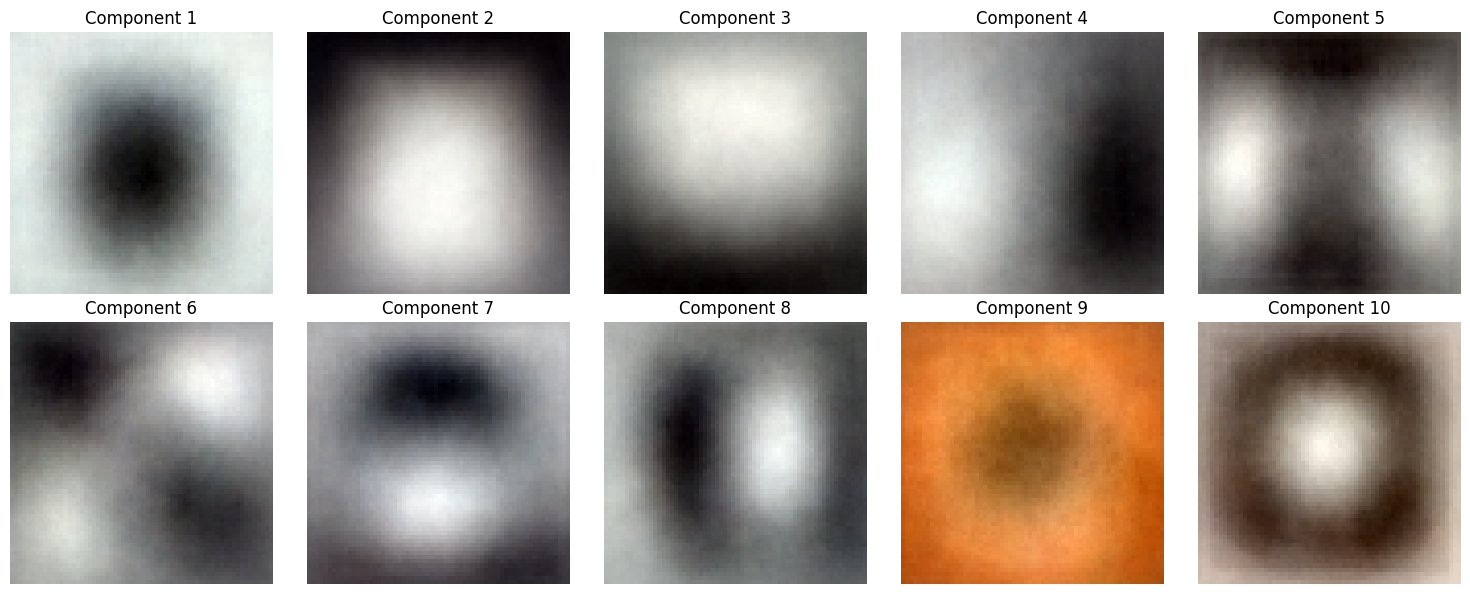

In [40]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()):
    if i >= len(pca.components_):
        break
    component = pca.components_[i].reshape(64, 64, 3)
    component_normalized = (component - component.min()) / (component.max() - component.min())
    ax.imshow(component_normalized)
    ax.set_title(f"Component {i+1}")
    ax.axis("off")
plt.tight_layout()
plt.show()


Первые 10 компонент отражают основные структуры и текстуры изображений:
        Компоненты выглядят как размытые формы или текстуры, которые могут быть связаны с характерными чертами кошек и собак (например, контуры глаз, шерсти и т. д.).
        Некоторые компоненты содержат цветовые паттерны (например, девятый компонент имеет яркие цвета).
         
     

Выводы по визуализации : 

    Первые компоненты PCA выделяют наиболее важные визуальные признаки изображений.
    Эти компоненты помогают понять, какие характеристики данных являются наиболее значимыми для классификации.
     

# Обучение моделей после PCA

In [ ]:
print("\n=== Результаты после PCA ===")
# Логистическая регрессия
lr_pca = LogisticRegression(max_iter=1000, C=1.0, random_state=42)
lr_pca.fit(X_train_pca, y_train)
accuracy_lr_pca = accuracy_score(y_test, lr_pca.predict(X_test_pca))
print(f"Logistic Regression (с PCA): {accuracy_lr_pca:.2f}")

# Дерево решений
tree_pca = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_pca.fit(X_train_pca, y_train)
accuracy_tree_pca = accuracy_score(y_test, tree_pca.predict(X_test_pca))
print(f"Decision Tree (с PCA): {accuracy_tree_pca:.2f}")


=== Результаты после PCA ===
Logistic Regression (с PCA): 0.60
Decision Tree (с PCA): 0.57


# График зависимости точности от числа компонент

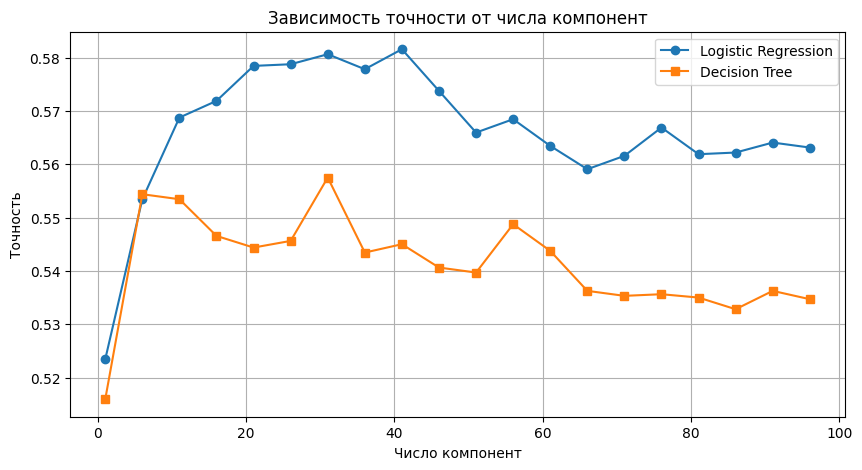

In [ ]:
n_components_range = range(1, min(100, X_train_pca.shape[1]), 5)
accuracies_lr = []
accuracies_tree = []

for n in n_components_range:
    # Логистическая регрессия
    lr_cv = LogisticRegression(max_iter=1000, C=1.0, random_state=42)
    scores = cross_val_score(lr_cv, X_train_pca[:, :n], y_train, cv=3)
    accuracies_lr.append(np.mean(scores))
    
    # Дерево решений
    tree_cv = DecisionTreeClassifier(max_depth=10, random_state=42)
    scores = cross_val_score(tree_cv, X_train_pca[:, :n], y_train, cv=3)
    accuracies_tree.append(np.mean(scores))

plt.figure(figsize=(10, 5))
plt.plot(n_components_range, accuracies_lr, marker='o', label="Logistic Regression")
plt.plot(n_components_range, accuracies_tree, marker='s', label="Decision Tree")
plt.title("Зависимость точности от числа компонент")
plt.xlabel("Число компонент")
plt.ylabel("Точность")
plt.legend()
plt.grid()
plt.show()

# Сравнение влияния PCA

In [ ]:
print("\n=== Сравнение влияния PCA ===")
print(f"Logistic Regression: {accuracy_lr_original:.2f} (без PCA) → {accuracy_lr_pca:.2f} (с PCA)")
print(f"Decision Tree: {accuracy_tree_original:.2f} (без PCA) → {accuracy_tree_pca:.2f} (с PCA)")


=== Сравнение влияния PCA ===
Logistic Regression: 0.56 (без PCA) → 0.60 (с PCA)
Decision Tree: 0.56 (без PCA) → 0.57 (с PCA)


Логистическая регрессия : 
    Улучшилась на 0.04  после применения PCA.
    Это связано с тем, что PCA помогает устранить шум и избыточные признаки, улучшая обобщающую способность линейной модели.
         

Дерево решений : 
    Имеет небольшое улучшение (+0.01 ) после PCA.
    Однако деревья решений менее чувствительны к размерности данных, поэтому их качество не сильно зависит от PCA.
         
     

## Вывод

    PCA положительно влияет на линейные модели  (логистическая регрессия), улучшая их точность за счет снижения размерности и устранения шума.
    Деревья решений менее чувствительны к PCA , так как они могут эффективно работать с полной размерностью данных.
    Оптимальное число компонент для 90% дисперсии : 355 компонент .
    Первые компоненты PCA  выделяют ключевые визуальные признаки изображений, такие как формы и текстуры.
     